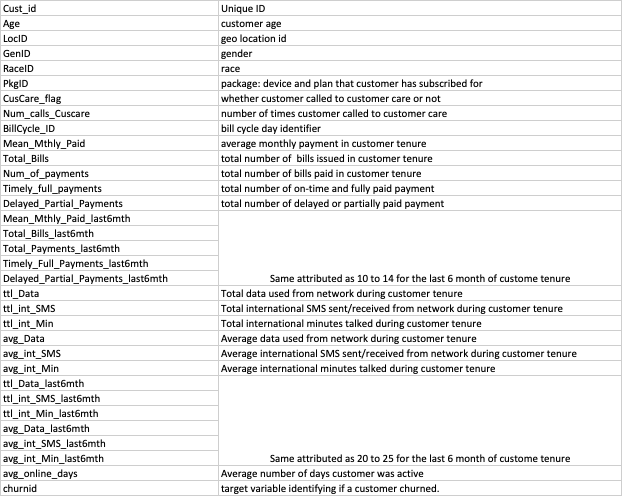

## Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import itertools
from itertools import cycle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

## Load the data
Split into train and test in 70:30 ratio, stratified on broad level categorical variables 
(as per excel description)

In [2]:
from sklearn.model_selection import train_test_split
df= pd.read_csv('total_data.csv')
train_df, test_df = train_test_split(df, test_size=0.3, random_state=2234, 
                                     stratify = df[['GenID', 'RaceID', 'churnid']])
#del df

Check for features with null values - Age is the only variable with null values

In [3]:
df[df.columns[df.isnull().any()]].isnull().sum()

Age    934
dtype: int64

# EDA
## Customer Attributes

Find out number of unique features in categorical features as per excel

In [4]:
train_df.iloc[:,1:10].nunique()

Age                     77
LocID                   17
GenID                    2
RaceID                   4
PkgID                  189
CusCare_flag             1
Num_calls_Cuscare        1
BillCycle_ID            10
Mean_Mthly_Paid      11672
dtype: int64

We can discard features CusCare_flag & Num_calls_Cuscare with zero variance

In [5]:
discard_cols = ['Cust_id','CusCare_flag', 'Num_calls_Cuscare']

#### Further clean data for categories with insignificant data & recategorize them into 999 category
Cut-off considered min rows in category should be >5 or atleast 3 customers churning
<br>\* For example Pkg ID distribution is as follows
investigate distribution of data and churn_% across categorical variables

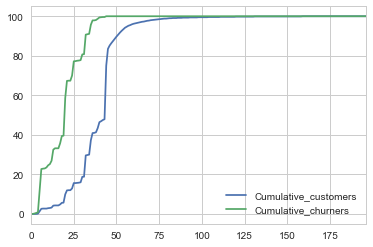

In [6]:
X = df.groupby(['PkgID']).apply(lambda x: pd.Series(dict(
            Tot_cust = x.churnid.count(),
            Churn_cust = x.churnid.sum(),
            Churn_per = round(100 * x.churnid.sum()/ x.churnid.count(),2),
        ))).reset_index().sort_values(['Churn_per','Churn_cust','Tot_cust'], ascending = False).reset_index(drop=True)
    
X['Cumulative_customers'] = round(100* X.Tot_cust.cumsum()/len(df),1)
X['Cumulative_churners'] = round(100* X.Churn_cust.cumsum()/df.churnid.sum(),1)
X.plot.line(y = ['Cumulative_customers','Cumulative_churners'])
del df

### This chart explains a lot in terms of distribution of customers in different PkgIDs and churn behavior as well
<br> ** About 25 PkgIds that represent < 20% of customers represent ~ 80% of churning customers **
<br> ** Variance in churn is only explained by ~ 40 PkgIDs, after which there is no information gain from PkgIDs, i.e all others can be grouped into one category with churn % ~ 0%, because the data is insignificant to derive any conclusion **

### Define a function that recategorizes categorical data, with all insignificant data categorized into one
Store the categories in dictionary for transformations on test data

In [7]:
def cat_recat(df,eda_col):
    X = df.groupby([eda_col]).apply(lambda x: pd.Series(dict(
            Tot_cust = x.churnid.count(),
            Churn_cust = x.churnid.sum()))).reset_index()
    Y = X[~((X['Tot_cust'] > 5) & (X['Churn_cust'] >= 3))][eda_col]
    df.loc[df[eda_col].isin(Y),eda_col] = 999
    
    X = df.groupby([eda_col]).apply(lambda x: pd.Series(dict(
            Tot_cust = x.churnid.count(),
            Churn_cust = x.churnid.sum(),
            Churn_per = round(100 * x.churnid.sum()/ x.churnid.count(),2),
        ))).reset_index().sort_values(['Churn_per','Churn_cust','Tot_cust'], ascending = False).reset_index(drop=True)
    
    return {eda_col: dict(zip(X[eda_col], X['Churn_per']))}; 

In [8]:
cat_cols = ['LocID', 'GenID','RaceID', 'PkgID', 'BillCycle_ID']
cat_dict={}
for i0 in cat_cols:
    cat_dict.update(cat_recat(train_df.copy(),i0))

### Defining a function that recategorizes based on categorical dictionary and also creates a encodings of categorical variable = churn rate as feature_vc

In [9]:
def cat_transform(df, catg_dict):
    for feat in catg_dict.keys():
        df.loc[~df[feat].isin(catg_dict[feat].keys()), feat] = 999
        df[feat + '_vc'] = df[feat].apply(lambda x: catg_dict[feat][x])

In [10]:
cat_transform(train_df, cat_dict)
train_df.groupby(['PkgID', 'PkgID_vc']).churnid.sum().reset_index().head()

,PkgID,PkgID_vc,churnid
0,1,59.34,432
1,2,59.03,477
2,3,48.00,48
3,4,50.00,4
4,5,28.39,356


PkgID_vc represents churn rate in each PkgID category in training data

### Defining an imputing function (to median) for continuous variables and also creating another variable that stores information for null (as feature_na)

In [11]:
def cont_impute(df, impute_col):
    df[impute_col + '_na'] = 0
    df.loc[df[impute_col].isnull(),impute_col + '_na'] = 1
    df.loc[df[impute_col].isnull(),impute_col] = df[impute_col].median()

#### Applying continous variables imputation to 'Age' (only feature with missing values)

In [12]:
cont_impute(train_df, 'Age')

# EDA for feature engineering and insights

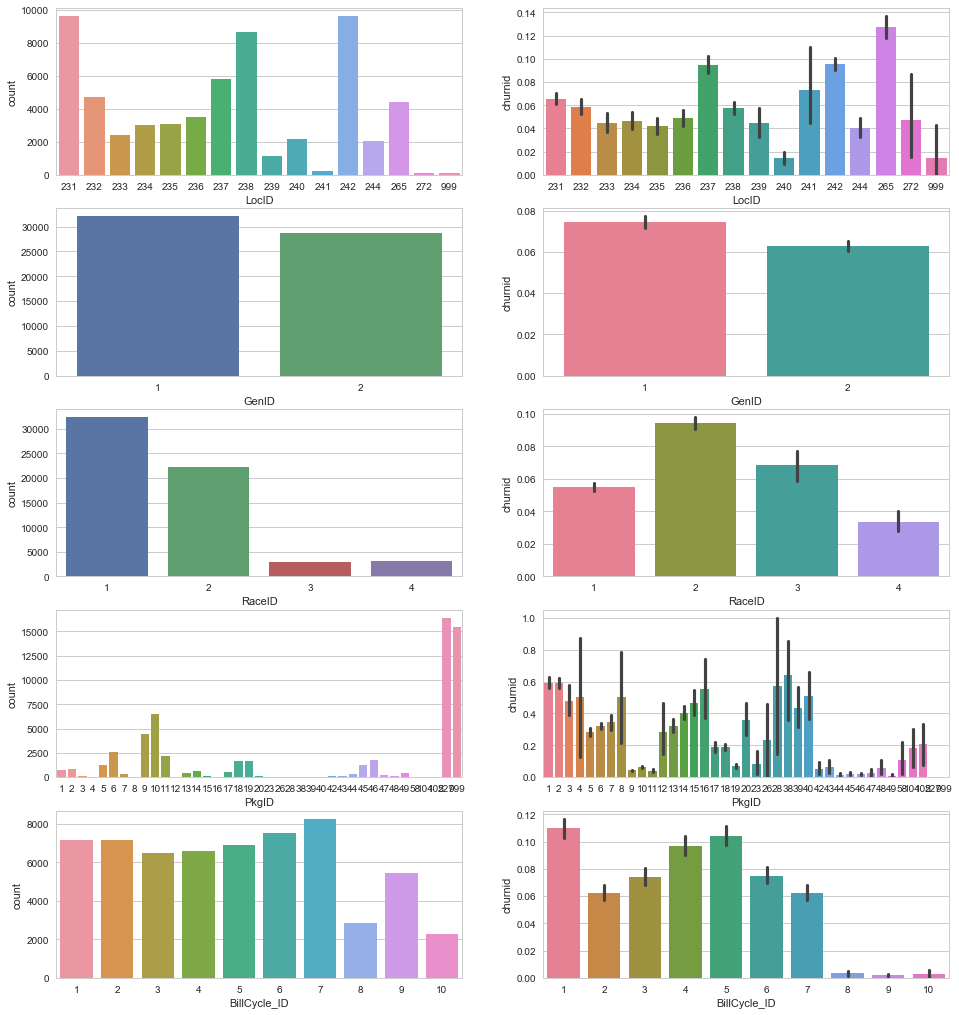

In [13]:
cat_cols = ['LocID', 'GenID','RaceID', 'PkgID', 'BillCycle_ID']
cat_cols_vc = ['LocID_vc', 'GenID_vc','RaceID_vc', 'PkgID_vc', 'BillCycle_ID_vc']
plt.figure(figsize=(16, 40))

for e, column in enumerate(cat_cols):
    plt.subplot(2 * len(cat_cols) + 1, 2, 2* e + 1)
    sns.countplot(train_df[column])
    plt.subplot(2 * len(cat_cols) + 1, 2, 2* e + 2)
    sns.barplot(data=train_df, x=column, y='churnid', palette="husl")

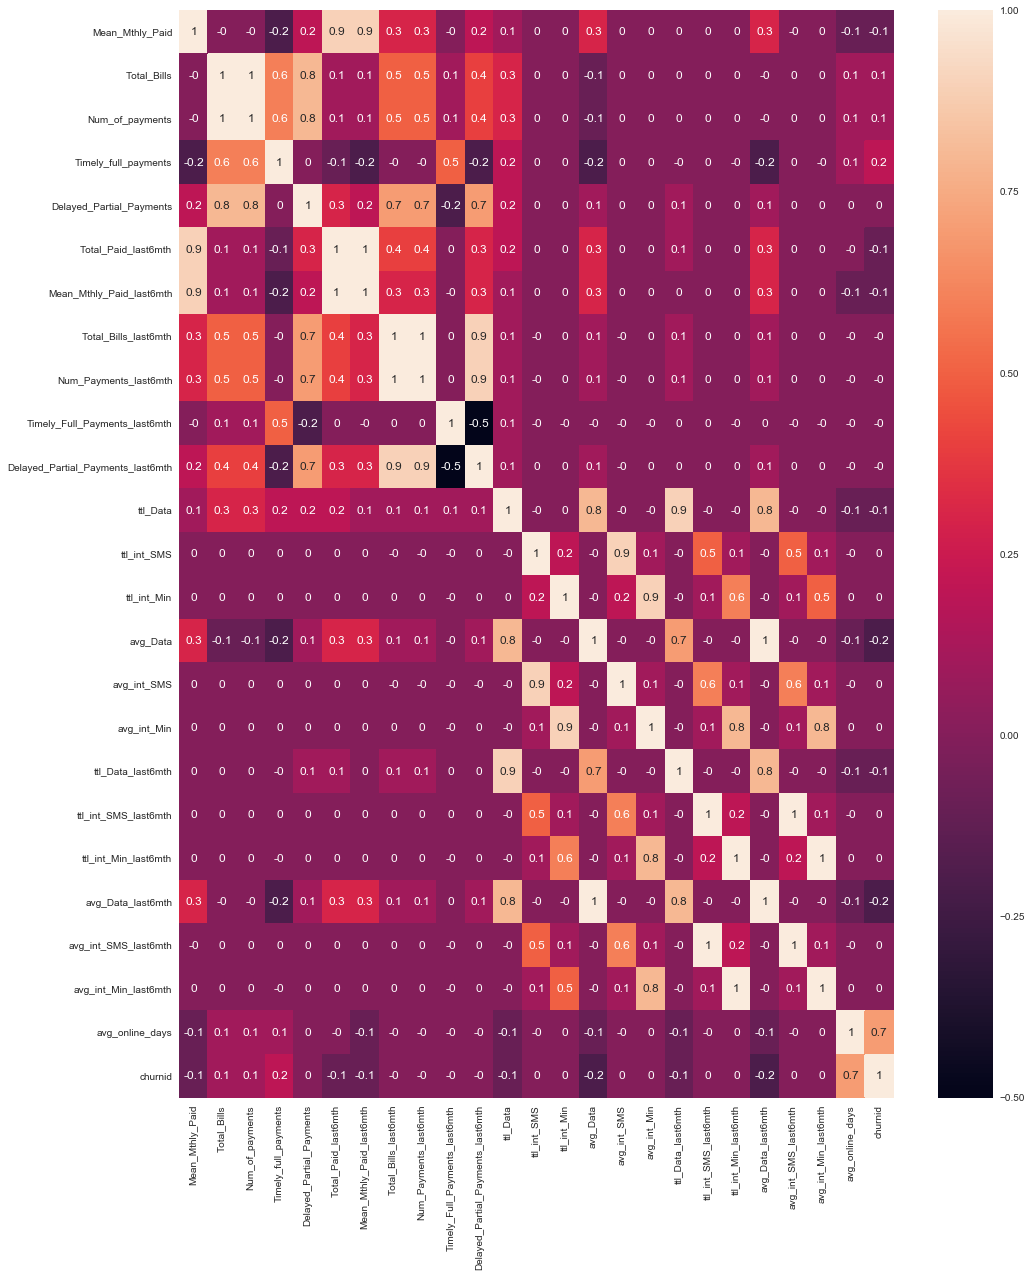

In [14]:
numeric_f = [x for x in list(test_df.columns)[8:] if x not in cat_cols]
plt.figure(figsize=(16, 20))

sns.heatmap(round(train_df.loc[:, numeric_f].corr(),1), annot=True)

The Correlation matrix shows strong correlation between 
1. total data and average data (both for total tenure and last 6 months), for ex ttl_data_last6mth & avg_Data_last6mth has correlation of 0.8
2. Number of payments to bills correlation is also high, instead encode them as number of payments to bills 
2. avg_online_days has very high correlation with dependent variable churn_id


#### First lets analyse total to average data
total/average gives out one tenure of customer in months, which can be seen when we divide total/average in last 6 months

In [15]:
train_df['tenure_last6mth'] = (train_df['ttl_Data_last6mth']/train_df['avg_Data_last6mth']).replace([np.inf, -np.inf, np.nan],0)
train_df['tenure_ttl'] = (train_df['ttl_Data']/train_df['avg_Data']).replace([np.inf, -np.inf, np.nan],0)
train_df[['ttl_Data_last6mth','avg_Data_last6mth','tenure_last6mth', 'tenure_ttl']].describe()

,ttl_Data_last6mth,avg_Data_last6mth,tenure_last6mth,tenure_ttl
count,6.067700e+04,60677.000000,60677.000000,60677.000000
mean,5.496705e+05,12063.863223,24.047849,15.118513
std,1.181827e+06,13162.466192,35.361272,9.078551
min,0.000000e+00,0.000000,0.000000,0.000000
25%,2.202676e+04,3972.880000,5.999997,8.000000
50%,4.211211e+04,7150.960000,6.000001,13.999988
75%,3.517569e+05,15453.380000,20.000007,20.999985
max,1.712881e+07,325562.780000,174.000021,45.000068


#### We can discard highly coorelated variables ttl & average now as the information is already captured in tenure features

In [16]:
discard_cols += ['avg_Data', 'avg_int_SMS', 'avg_int_Min', 'avg_Data_last6mth', 'avg_int_SMS_last6mth',
                    'avg_int_Min_last6mth']

Similarly capturing Payments to bills ratio and discarding Payments
<br>and Delayed payments = Total Payments - Timely Payments 

In [17]:
train_df['Payments_Bills'] = (train_df['Num_of_payments']/train_df['Total_Bills']).replace([np.inf, -np.inf, np.nan],0)
train_df['Timely_Payments'] = (train_df['Timely_full_payments']/train_df['Num_of_payments']).replace([np.inf, -np.inf, np.nan],0)
#train_df['Delayed_Payments'] = train_df['Delayed_Partial_Payments']/train_df['Num_of_payments']
train_df['Payments_Bills_last6mth'] = (train_df['Num_Payments_last6mth']/train_df['Total_Bills_last6mth']).replace([np.inf, -np.inf, np.nan],0)
train_df['Timely_Payments_last6mth'] = (train_df['Timely_Full_Payments_last6mth']/train_df['Num_Payments_last6mth']).replace([np.inf, -np.inf, np.nan],0)
#train_df['Delayed_Payments_last6mth'] = train_df['Delayed_Partial_Payments_last6mth']/train_df['Num_Payments_last6mth']
train_df['Mean_Total_Paid_last6mth'] = (train_df['Mean_Mthly_Paid_last6mth']/train_df['Total_Paid_last6mth']).replace([np.inf, -np.inf, np.nan],0)

discard_cols += ['Num_of_payments', 'Timely_full_payments', 'Delayed_Partial_Payments', 
                'Num_Payments_last6mth', 'Timely_Full_Payments_last6mth', 'Delayed_Partial_Payments_last6mth',
                'Mean_Mthly_Paid_last6mth']

In [18]:
numeric_f = [x for x in list(train_df.columns) if x not in cat_cols + discard_cols +cat_cols_vc]
train_df[numeric_f].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,60677.0,35.925029,1.190283e+01,2.000000,26.000000,34.000000,44.000000,9.600000e+01
Mean_Mthly_Paid,60677.0,93.488945,3.472623e+01,3.130000,72.650000,88.460000,106.470000,1.458670e+03
Total_Bills,60677.0,17.398767,1.220086e+01,1.000000,9.000000,15.000000,23.000000,6.710000e+02
Total_Paid_last6mth,60677.0,509.707006,2.164340e+02,0.000000,402.600000,486.500000,574.300000,1.204550e+04
Total_Bills_last6mth,60677.0,6.105246,3.381343e+00,0.000000,5.000000,6.000000,6.000000,1.560000e+02
ttl_Data,60677.0,165194.320108,1.883851e+05,0.000000,51286.280000,104857.020000,203779.900000,3.355903e+06
ttl_int_SMS,60677.0,0.072004,3.593864e+00,0.000000,0.000000,0.000000,0.000000,6.030000e+02
ttl_int_Min,60677.0,1.357372,4.048050e+01,0.000000,0.000000,0.000000,0.000000,3.587460e+03
ttl_Data_last6mth,60677.0,549670.522792,1.181827e+06,0.000000,22026.760000,42112.110000,351756.920000,1.712881e+07
ttl_int_SMS_last6mth,60677.0,0.009509,8.231592e-01,0.000000,0.000000,0.000000,0.000000,1.640000e+02


Payments_Bills and Payments_Bills_last6mth have zero variance, hence adding them to discarded cols

In [19]:
discard_cols += ['Payments_Bills', 'Payments_Bills_last6mth']

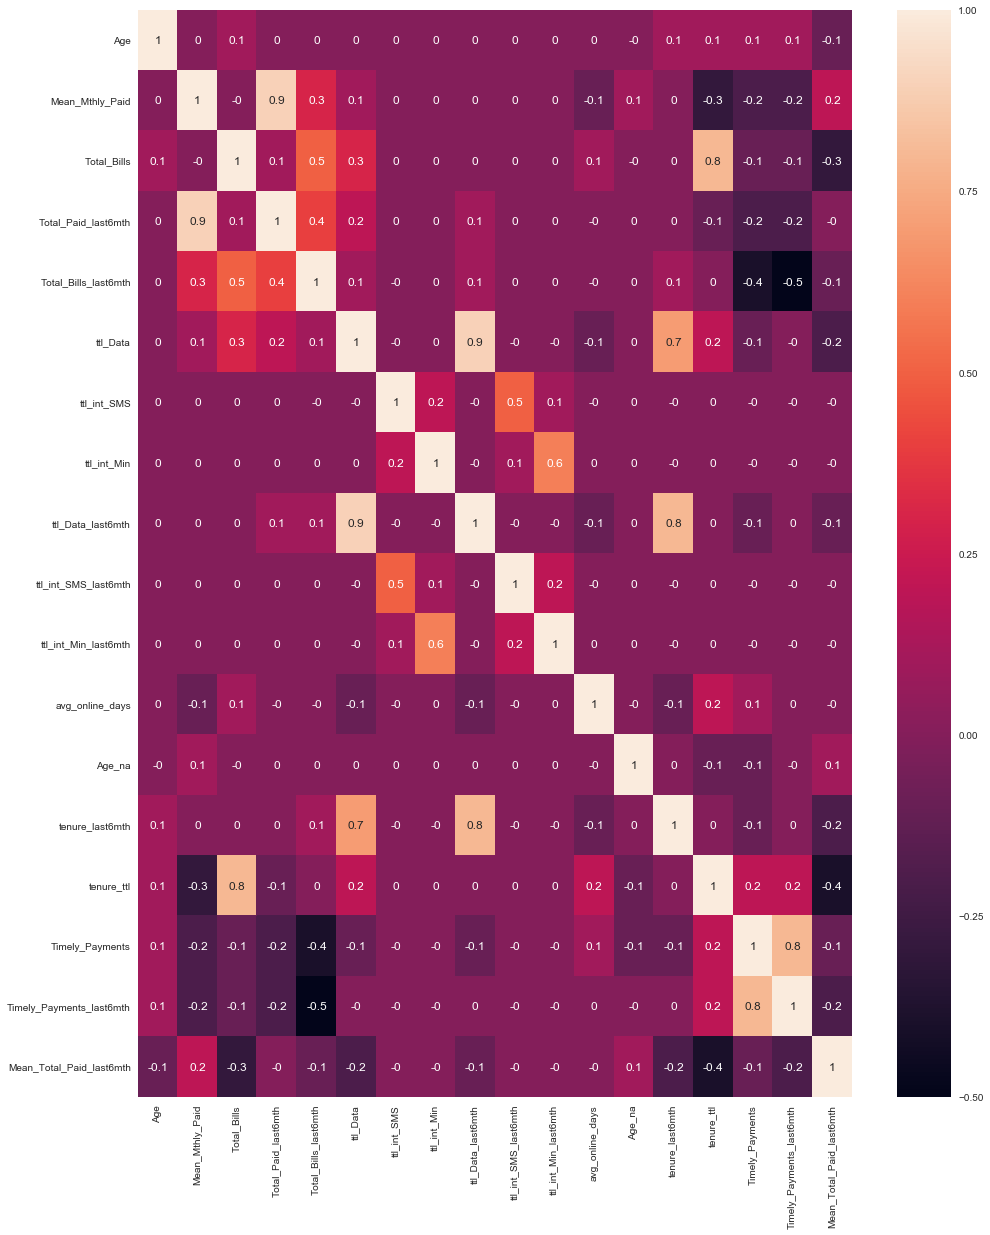

In [20]:
numeric_f = [x for x in list(train_df.columns) if x not in cat_cols + discard_cols +cat_cols_vc + ['churnid']]
plt.figure(figsize=(16, 20))

sns.heatmap(round(train_df.loc[:, numeric_f].corr(),1), annot=True)

#### Now that we have reduced multiple collinearity amongst features, we can apply get_dummies for creating sparse matrices of categorical data

In [21]:
train_df = pd.get_dummies(train_df, columns = cat_cols, prefix = cat_cols, 
                          dummy_na=False, drop_first=True)

In [22]:
train_features = [i0 for i0 in list(train_df) if i0 not in discard_cols + ['churnid']]

from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [23]:
X_train = train_df.loc[:,train_features]
y_train = train_df.loc[:,'churnid']

In [24]:
def transform_pipeline(df, cat_dict, train_features):
    cat_transform(df, cat_dict)
    cont_impute(df, 'Age')
    df['tenure_last6mth'] = (df['ttl_Data_last6mth']/df['avg_Data_last6mth']).replace([np.inf, -np.inf, np.nan],0)
    df['tenure_ttl'] = (df['ttl_Data']/df['avg_Data']).replace([np.inf, -np.inf, np.nan],0)
    df['Payments_Bills'] = (df['Num_of_payments']/df['Total_Bills']).replace([np.inf, -np.inf, np.nan],0)
    df['Timely_Payments'] = (df['Timely_full_payments']/df['Num_of_payments']).replace([np.inf, -np.inf, np.nan],0)
    #df['Delayed_Payments'] = df['Delayed_Partial_Payments']/df['Num_of_payments']
    df['Payments_Bills_last6mth'] = (df['Num_Payments_last6mth']/df['Total_Bills_last6mth']).replace([np.inf, -np.inf, np.nan],0)
    df['Timely_Payments_last6mth'] = (df['Timely_Full_Payments_last6mth']/df['Num_Payments_last6mth']).replace([np.inf, -np.inf, np.nan],0)
    #df['Delayed_Payments_last6mth'] = df['Delayed_Partial_Payments_last6mth']/df['Num_Payments_last6mth']
    df['Mean_Total_Paid_last6mth'] = (df['Mean_Mthly_Paid_last6mth']/df['Total_Paid_last6mth']).replace([np.inf, -np.inf, np.nan],0)
    
    df = pd.get_dummies(df, columns = cat_cols, prefix = cat_cols, 
                              dummy_na=False, drop_first=False)
    for i0 in [x for x in train_features if x not in list(df)]:
        df[i0] = 0
    
    return df.loc[:,train_features], df.loc[:,'churnid']

## As we set seed to a constant, we can reload data to obtain train & test datasets

In [25]:
df= pd.read_csv('total_data.csv')
train_df, test_df = train_test_split(df, test_size=0.3, random_state=2234, 
                                     stratify = df[['GenID', 'RaceID', 'churnid']])
X_train, y_train = transform_pipeline(train_df, cat_dict, train_features)
X_test, y_test = transform_pipeline(test_df, cat_dict, train_features)

In [26]:
#Apply standard scaler to improve model execution times for linear models
from sklearn.preprocessing import StandardScaler
std_scalar = StandardScaler()
std_scalar.fit(train_df[numeric_f])
X_train[numeric_f] = std_scalar.transform(X_train[numeric_f])
X_test[numeric_f] = std_scalar.transform(X_test[numeric_f])

# Modeling starts here

## Lets start with a simplistic linear model (logistic regression with l1 regularization)

In [31]:
def model_test(model, X_test, y_test):
    from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, precision_score
    import scikitplot as skplt
    %matplotlib inline
    
    # Model Prediction 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    #Print the classification report
    print(classification_report(y_true =y_test,y_pred = y_pred))
    
    sns.heatmap(confusion_matrix(y_test,y_pred,labels=[0,1]), annot=True, fmt="d", linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    skplt.metrics.plot_cumulative_gain(y_test, y_prob)
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    print ('AUC: ' + str(round(auc(fpr, tpr) * 100,1)) + '%')
    
    skplt.metrics.plot_roc_curve(y_test, y_prob)
    plt.show()
    
    #Lift chart
    df = pd.DataFrame({'y_test':y_test, 'y_prob':y_prob[:,1]})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True).reset_index()
    df['decile'] = pd.qcut(df['index'], 10, labels= range(1,11,1))
    df = df.groupby(['decile']).apply(lambda x: pd.Series(dict(
        Customers = x.y_test.count(),
        Churn = x.y_test.sum(),
        Churn_rate = x.y_test.sum()/x.y_test.count()
    ))).reset_index().sort_values(['decile'], ascending = True)
    df['gains'] = df.Churn.cumsum()/df.Churn.sum()
    df['lift'] = df.Churn_rate/(df.Churn.sum()/df.Customers.sum())
    df['cum_lift'] = (df.Churn.cumsum()/df.Customers.cumsum())/(df.Churn.sum()/df.Customers.sum())
    df.plot.line(x='decile', y=['lift','cum_lift'])


In [28]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver = 'liblinear', penalty = 'l1')
# ravel() simply creates a flattened array
lr_model.fit(X_train, y_train.values.ravel())

y_pred = lr_model.predict(X_test)
print('Accuracy of logistic classifier on train, test set: {:.2f}%'
      .format(lr_model.score(X_train, y_train)*100),
      '{:.2f}%'.format(lr_model.score(X_test, y_test)*100))

Accuracy of logistic classifier on train, test set: 100.00% 100.00%


Hola! The model gives out 100% accuracy (100% AUC as well)

### Model Interpretation - from coefficients

In [29]:
coefs = pd.DataFrame({'Feature': train_features, 'Coef':lr_model.coef_[0]})
pd.concat([coefs.sort_values('Coef', ascending=False).reset_index(drop=True)[:6],
           coefs.sort_values('Coef').reset_index(drop=True)[:6]],axis=1)

,Coef,Feature,Coef,Feature
0,18.563313,avg_online_days,-3.375684,GenID_2
1,0.100538,tenure_ttl,-3.316948,GenID_vc
2,0.044990,PkgID_vc,-0.041069,LocID_vc
3,0.000000,Age,-0.038774,RaceID_vc
4,0.000000,PkgID_18,0.000000,Age
5,0.000000,PkgID_39,0.000000,PkgID_38


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     24214
          1       1.00      1.00      1.00      1791

avg / total       1.00      1.00      1.00     26005



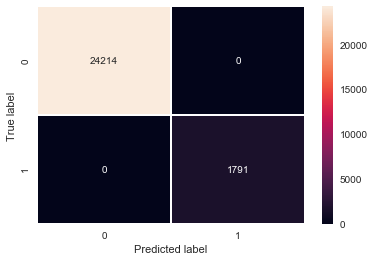

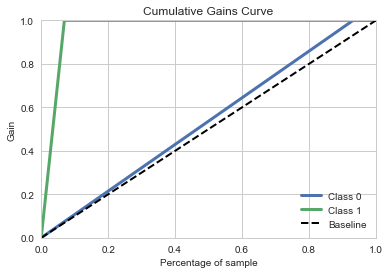

AUC: 100.0%


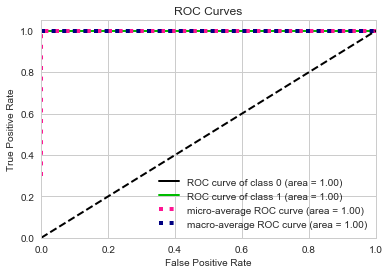

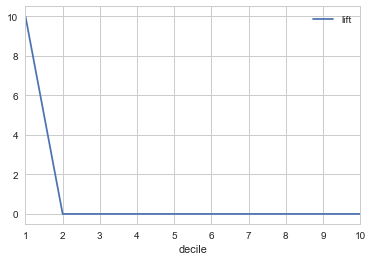

In [30]:
df_t = model_test(lr_model,X_test,y_test)

#### avg_online_days, as seen in correlation matrix explains ~ 70% of churning,
<br>while handful of other features (PackageID, Billing Cycle, Gender and Race) explain the rest

## Same is the case with advanced algorithms like Random Forest with just a single tree

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1, random_state = 2234, n_jobs = -1, max_depth=5, \
                                           min_samples_leaf = 5, criterion = 'entropy', max_features = 0.25,
                                      bootstrap=True, oob_score=True)
#fitting the model
rf_classifier.fit(X_train, y_train.values.ravel())

y_pred = rf_classifier.predict(X_test)
print('Accuracy of RF classifier on train, test set: {:.2f}%'
      .format(rf_classifier.score(X_train, y_train)*100),
      '{:.2f}%'.format(rf_classifier.score(X_test, y_test)*100))

Accuracy of RF classifier on train, test set: 99.98% 99.96%


(-0.5, 5.5)

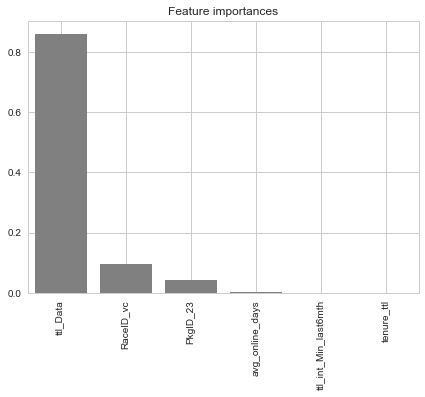

In [43]:
importance_ls = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
importance_ls, train_features, std = (list(t) for t in zip(*sorted(zip(importance_ls, train_features, std), reverse=True)))

plt.figure(figsize=(7,5))
plt.title("Feature importances")
plt.bar(range(len(train_features[0:6])), importance_ls[0:6], color='gray', yerr=std[0:6], ecolor='black', align="center")
plt.xticks(range(len(train_features[0:6])), train_features[0:6], rotation='vertical')
plt.xlim([-0.5, len(train_features[0:6])-0.5])

avg_online_days feature is highly coorelated with churn and explains more than 70% of variance in churn rate

## For showing my hyper parameter tuning skills, 
## I have excluded avg_online_days and built the models below

In [27]:
mod_train_features = [x for x in train_features if x != 'avg_online_days']
X_train = X_train.loc[:,mod_train_features]
X_test = X_test.loc[:,mod_train_features]

In [45]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver = 'liblinear', penalty = 'l1')
# ravel() simply creates a flattened array
lr_model.fit(X_train, y_train.values.ravel())

y_pred = lr_model.predict(X_test)
print('Accuracy of logistic classifier on train, test set: {:.2f}%'
      .format(lr_model.score(X_train, y_train)*100),
      '{:.2f}%'.format(lr_model.score(X_test, y_test)*100))

Accuracy of logistic classifier on train, test set: 94.28% 94.30%


In [46]:
coefs = pd.DataFrame({'Feature': mod_train_features, 'Coef':lr_model.coef_[0]})
pd.concat([coefs.sort_values('Coef', ascending=False).reset_index(drop=True)[:10],
           coefs.sort_values('Coef').reset_index(drop=True)[:10]],axis=1)

,Coef,Feature,Coef,Feature
0,1.509273,tenure_last6mth,-5.410024,PkgID_227
1,0.711999,PkgID_26,-5.314167,PkgID_999
2,0.635678,PkgID_6,-1.972082,ttl_Data_last6mth
3,0.628315,BillCycle_ID_2,-1.413296,PkgID_49
4,0.627157,PkgID_5,-1.102527,PkgID_44
5,0.617727,RaceID_2,-1.012317,PkgID_46
6,0.583856,PkgID_18,-0.916072,LocID_240
7,0.524785,BillCycle_ID_6,-0.757965,GenID_2
8,0.502934,PkgID_23,-0.670331,PkgID_45
9,0.483292,BillCycle_ID_7,-0.644868,PkgID_11


             precision    recall  f1-score   support

          0       0.95      0.99      0.97     24214
          1       0.68      0.33      0.44      1791

avg / total       0.93      0.94      0.93     26005



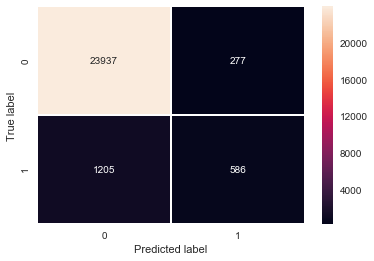

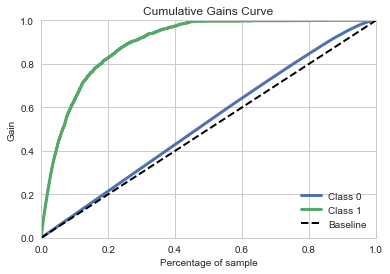

AUC: 92.5%


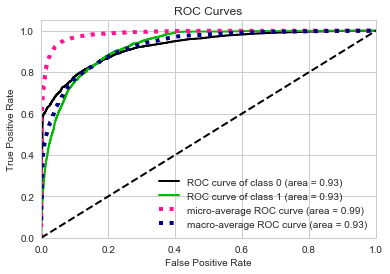

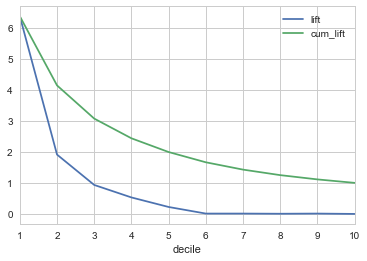

In [49]:
model_test(lr_model,X_test,y_test)

#### Highlights:
1. Tenure_6mth which indicates average number of accounts with a customer (assuming multiple account holders will have > 6mth tenure) is highly correlated with churn
2. Gains chart shows that 20% of customers captures >80% of churn customers
<br>Implies a lift of 6x, 4x, 3x when 10%,20%, 30% of customers are chosen


## Building churn model using Random Forest
Lets consider only AUC score, as the problem at hand is about lift, identifying churn customers in top deciles

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
def rf_fit_score(params):
    rf_classifier = RandomForestClassifier(n_jobs= -1, bootstrap=True, oob_score=True)
    rf_classifier.set_params(**params)
    #fitting the model
    rf_classifier.fit(X_train, y_train.values.ravel())
    
    y_train_pred = rf_classifier.predict_proba(X_train)[:,1]
    y_pred = rf_classifier.predict_proba(X_test)[:,1]
    auc_train = roc_auc_score(y_train,y_train_pred)
    auc_oob = roc_auc_score(y_train,np.nan_to_num(rf_classifier.oob_decision_function_[:,1]))
    auc_test = roc_auc_score(y_test, y_pred)

    print('AUC of RF classifier on train, out_of_bag, test set: {:.2f}%'
          .format(auc_train*100),
          '{:.2f}%'.format(auc_oob*100),
          '{:.2f}%'.format(auc_test*100))
    return rf_classifier

<br>First using a base Random Classifier with default options, 
<br>no of parallel trees, n_estimators = 10
<br>Min rows needed in a leaf for split, min_samples_leaf = 1
<br>No of features to be used at each node, max_features = 1

In [99]:
rf = rf_fit_score({})

AUC of RF classifier on train, out_of_bag, test set: 99.99% 87.24% 94.35%


## Looks like out of bag score and test validation score are way off train score
<br> Fine tune max_depth [1,20]

AUC of RF classifier on train, out_of_bag, test set: 99.99% 85.97% 93.89%


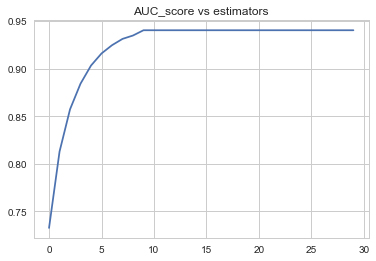

In [119]:
rf = rf_fit_score({'max_depth': 30})
preds = np.stack([t.predict(X_test) for t in rf.estimators_])
plt.plot([roc_auc_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(30)])
plt.title("AUC_score vs estimators");

## Next we tune on minimum samples needed to split a tree

In [117]:
for min_samples_leaf in [1,2,5,10,15,20,25,30,35,50,75,100,200,400]:
    #print('min_samples_leaf: ',min_samples_leaf)
    rf = rf_fit_score({'max_depth': 30, 'min_samples_leaf' : min_samples_leaf})

AUC of RF classifier on train, out_of_bag, test set: 99.99% 86.80% 94.60%
AUC of RF classifier on train, out_of_bag, test set: 99.86% 91.28% 96.14%
AUC of RF classifier on train, out_of_bag, test set: 99.23% 93.58% 96.42%
AUC of RF classifier on train, out_of_bag, test set: 98.52% 94.72% 96.62%
AUC of RF classifier on train, out_of_bag, test set: 98.13% 95.07% 96.51%
AUC of RF classifier on train, out_of_bag, test set: 97.93% 94.96% 96.50%
AUC of RF classifier on train, out_of_bag, test set: 97.61% 94.76% 96.37%
AUC of RF classifier on train, out_of_bag, test set: 97.44% 95.07% 96.36%
AUC of RF classifier on train, out_of_bag, test set: 97.32% 94.71% 96.33%
AUC of RF classifier on train, out_of_bag, test set: 97.18% 94.98% 96.36%
AUC of RF classifier on train, out_of_bag, test set: 96.82% 94.92% 96.19%
AUC of RF classifier on train, out_of_bag, test set: 96.35% 94.00% 95.72%
AUC of RF classifier on train, out_of_bag, test set: 96.00% 94.05% 95.50%
AUC of RF classifier on train, out_of_

#### Fine tuning max features at each tree split

In [118]:
for max_feat in ['sqrt', 'log2', 0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    #print('max_features: ',max_feat)
    rf = rf_fit_score({'max_depth': 100, 'min_samples_leaf' : 20,'max_features' : max_feat})

AUC of RF classifier on train, out_of_bag, test set: 97.76% 95.09% 96.30%
AUC of RF classifier on train, out_of_bag, test set: 97.33% 94.44% 95.99%
AUC of RF classifier on train, out_of_bag, test set: 98.15% 95.19% 96.71%
AUC of RF classifier on train, out_of_bag, test set: 98.33% 95.45% 96.79%
AUC of RF classifier on train, out_of_bag, test set: 98.30% 95.28% 96.80%
AUC of RF classifier on train, out_of_bag, test set: 98.36% 95.36% 96.75%
AUC of RF classifier on train, out_of_bag, test set: 98.45% 95.52% 96.84%
AUC of RF classifier on train, out_of_bag, test set: 98.50% 95.42% 96.89%
AUC of RF classifier on train, out_of_bag, test set: 98.52% 95.38% 96.91%
AUC of RF classifier on train, out_of_bag, test set: 98.52% 95.49% 96.90%
AUC of RF classifier on train, out_of_bag, test set: 98.54% 95.50% 96.91%
AUC of RF classifier on train, out_of_bag, test set: 88.42% 79.03% 87.90%


In [159]:
def best_param(X_train, y_train):
    # Random Forest Classification
    from sklearn.model_selection import GridSearchCV
 
    # Number of trees in random forest
    n_estimators = [5,10,25, 35, 50,75, 100,200,500]
    # Number of features to consider at every split
    max_features = ['sqrt',0.25, 0.33, 0.5, 0.75]
    # Maximum number of levels in tree
    max_depth = [5,6,7,8,10,15,25]
    # Minimum number of samples required to split a node
    min_samples_split = [50, 100, 250, 500, 1000]
    
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [5, 10,25,50,100,200, 500]
    # Method of selecting samples for training each tree
    #bootstrap = [True]
    #criterion = 'entropy'
    # Create the random grid
    param_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}


    
    rf_classifier = RandomForestClassifier(random_state = 2234, n_jobs = -1)
    #fitting the model
    CV_rfc = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 3)
    CV_rfc.fit(X_train, y_train)
    print (CV_rfc.best_params_)
    
    return CV_rfc

In [35]:
#Best params
rf = rf_fit_score({'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf' : 100,'max_features' : 0.25})

AUC of RF classifier on train, out_of_bag, test set: 97.03% 96.64% 96.47%


             precision    recall  f1-score   support

          0       0.96      0.99      0.97     24214
          1       0.79      0.37      0.50      1791

avg / total       0.94      0.95      0.94     26005



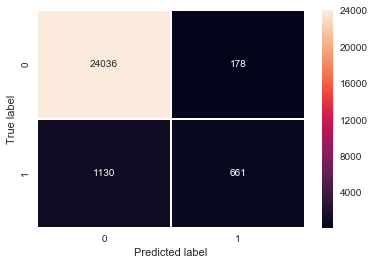

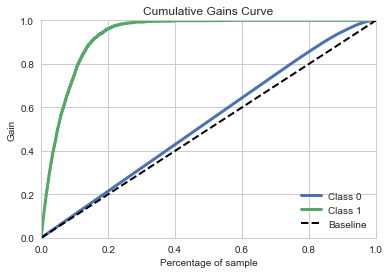

AUC: 96.5%


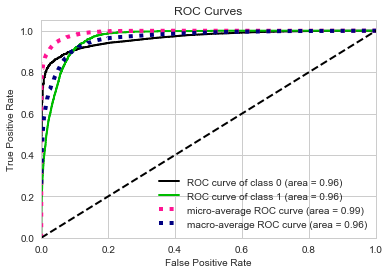

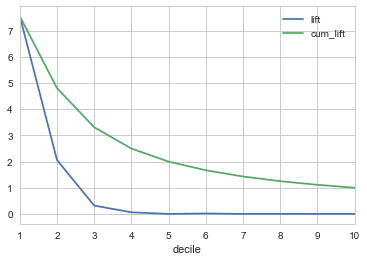

In [36]:
model_test(rf,X_test,y_test)

(-0.5, 14.5)

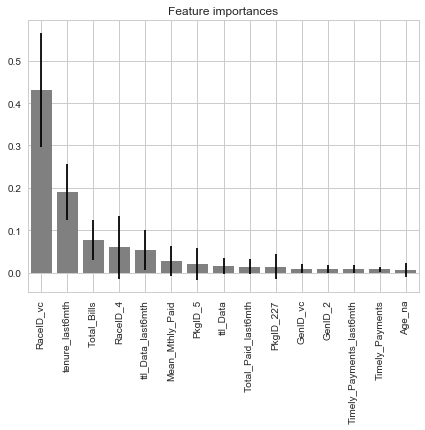

In [37]:
importance_ls = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
importance_ls, train_features, std = (list(t) for t in zip(*sorted(zip(importance_ls, train_features, std), reverse=True)))

plt.figure(figsize=(7,5))
plt.title("Feature importances")
plt.bar(range(len(train_features[0:15])), importance_ls[0:15], color='gray', yerr=std[0:15], ecolor='black', align="center")
plt.xticks(range(len(train_features[0:15])), train_features[0:15], rotation='vertical')
plt.xlim([-0.5, len(train_features[0:15])-0.5])

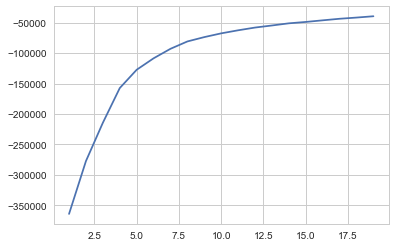

In [38]:
cluster_cols = ['tenure_last6mth', 'Total_Bills', 'RaceID_4', 'ttl_Data_last6mth',
               'Mean_Mthly_Paid', 'PkgID_5']
from  sklearn.cluster  import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
standardized_X = preprocessing.scale(X_train[cluster_cols])

Nc = range(1,20)
kmeans=[KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(standardized_X).score(standardized_X) for i in range(len(kmeans))]
plt.plot(Nc,score)

## Ideal cluster size = 8

In [40]:
X_train, y_train = transform_pipeline(train_df, cat_dict, train_features)
cluster_cols = ['tenure_last6mth', 'Total_Bills', 'RaceID_4', 'ttl_Data_last6mth',
               'Mean_Mthly_Paid', 'PkgID_5']
from  sklearn.cluster  import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
standardized_X = preprocessing.scale(X_train[cluster_cols])
kmeans_visit = KMeans(n_clusters=8)
kmeans_visit1 = kmeans_visit.fit(standardized_X)
X_train['CLUSTER']= kmeans_visit1.predict(standardized_X)
X_train['churnid'] = y_train

Clustering for actionable insights

In [41]:
X_train.groupby(['CLUSTER']).apply(lambda x: pd.Series(dict(
        RaceID_4 = x.RaceID_4.sum()/x.RaceID_2.count(),
        tenure_last6mth = x.tenure_last6mth.mean(),
        PkgID_5 = x.PkgID_5.sum()/x.PkgID_5.count(),
        Total_Bills = x.Total_Bills.mean(),
        ttl_Data_last6mth = x.ttl_Data_last6mth.mean(),
        Mean_Mthly_Paid = x.Mean_Mthly_Paid.mean(),
        Churn = x.churnid.sum()/x.churnid.count(),
        Cust =x.churnid.count()
    ))).reset_index().sort_values(['Churn'], ascending = False).reset_index(drop=True).drop('CLUSTER', axis=1)

,Churn,Cust,Mean_Mthly_Paid,PkgID_5,RaceID_4,Total_Bills,tenure_last6mth,ttl_Data_last6mth
0,0.283892,1254.0,57.528549,1.0,0.019139,28.782297,5.884369,2.236311e+04
1,0.169452,10233.0,80.786643,0.0,0.000000,33.329229,6.327452,4.407034e+04
2,0.095588,408.0,300.746078,0.0,0.080882,52.887255,5.776962,1.213812e+05
3,0.079261,21486.0,74.815196,0.0,0.000000,13.574886,5.848714,3.464436e+04
4,0.032289,3097.0,109.258615,0.0,1.000000,13.703584,23.704555,6.656577e+05
5,0.019683,12041.0,127.183954,0.0,0.000000,9.734989,11.072474,1.765676e+05
6,0.001966,3052.0,88.614807,0.0,0.018676,23.891219,116.986894,4.372648e+06
7,0.000549,9106.0,99.205602,0.0,0.000000,14.576213,76.347503,1.597467e+06
